In [1]:
import numpy as np

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [2]:
hits = np.genfromtxt("./data/hits.csv", delimiter=",", skip_header=1)

In [3]:
def get_hits(data, event_n):
    event = data[data[:, 0] == event_n][:,-3:]
    return event

def plot_event(event, track_ns=None):
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(num=None, figsize=(16, 8), dpi=400)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(event[:, 2], event[:, 0], event[:, 1], color="b", alpha=0.25, s = 1.0)
    
    if track_ns is not None:
        for i in range(track_ns.shape[0]):
            (nx, ny, nz) = track_ns[i, :]
            ax.plot([0, nz], [0, nx], [0, ny], c = "r", linewidth=1.0, alpha=0.25)

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_ylim([-150, 150])
    ax.set_zlim([-150, 150])

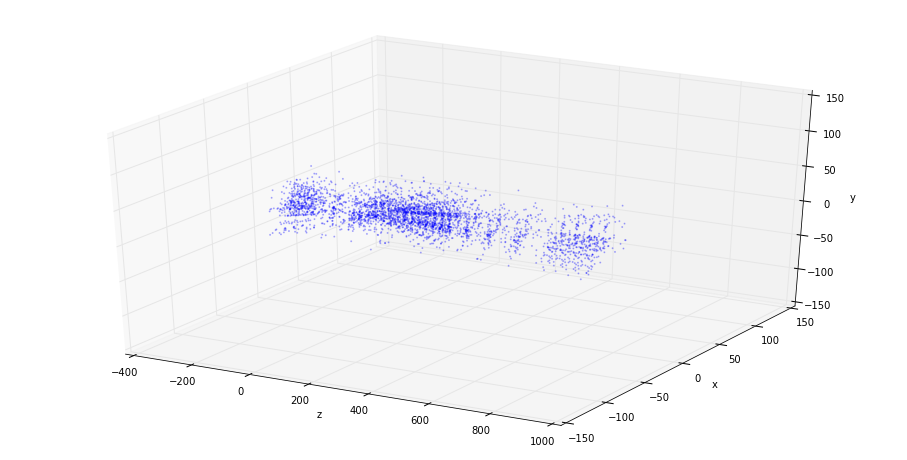

In [4]:
event_0 = get_hits(hits, event_n = 0)
plot_event(event_0)

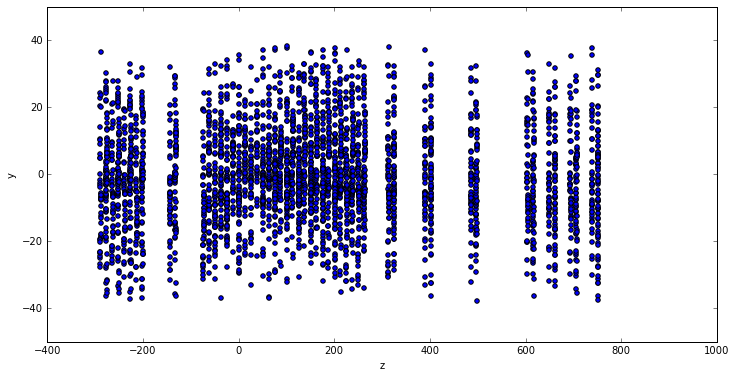

In [5]:
plt.figure(num=None, figsize=(12, 6), dpi=400)
plt.scatter(event_0[:, 2], event_0[:, 1])
plt.xlabel("z")
plt.ylabel("y")
plt.show()

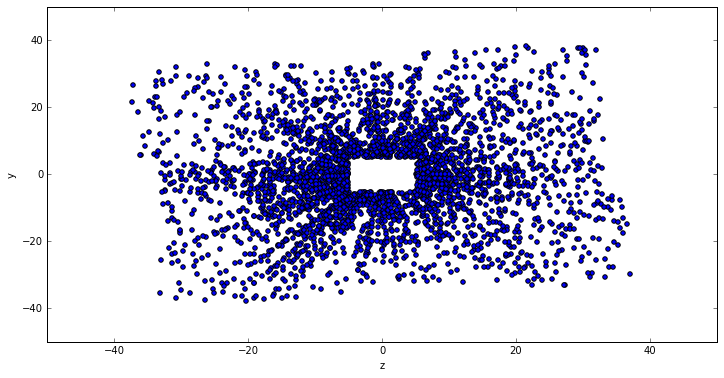

In [6]:
plt.figure(num=None, figsize=(12, 6), dpi=400)
plt.scatter(event_0[:, 0], event_0[:, 1])
plt.xlabel("z")
plt.ylabel("y")
plt.show()

In [7]:
def retina_response(n, event, sigma=1.0):
    """
        event: N x 3 matrix
        n: 1 x 3 vector
    """
    projections = np.ndarray(shape=event.shape, dtype="float64")
    scalar = event.dot(n)
    
    projections[:, 0] = scalar * n[0]
    projections[:, 1] = scalar * n[1]
    projections[:, 2] = scalar * n[2]
    
    deltas = event - projections
    s = np.sum(deltas[scalar > 0.0] * deltas[scalar > 0.0], axis=1)
    return np.sum(np.exp(-s / 2 / sigma / sigma))

def from_angular(theta, phi):
    n = np.array([np.cos(theta), np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi)])
    return n.T

def to_angular(p):
    norm = np.sqrt(np.sum(p * p, axis=1))
    theta = np.arccos(p[:, 0] / norm)
    phi = np.arctan2(p[:, 2], p[:, 1])
    return np.vstack([theta, phi]).T

def retina_angular(theta, phi, event, sigma=1.0):
    n = np.array([np.cos(theta), np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi)])
    return retina_response(n, event, sigma)

def retina_response_grid(event, sigma=1.0, grid_bins = 100):
    thetas, phis = np.meshgrid(np.linspace(0,      np.pi, num=grid_bins),
                               np.linspace(-np.pi, np.pi, num=grid_bins))
    response = np.vectorize(lambda t, p: retina_angular(t, p, event_0, sigma=sigma))(thetas, phis)
    return response, thetas, phis

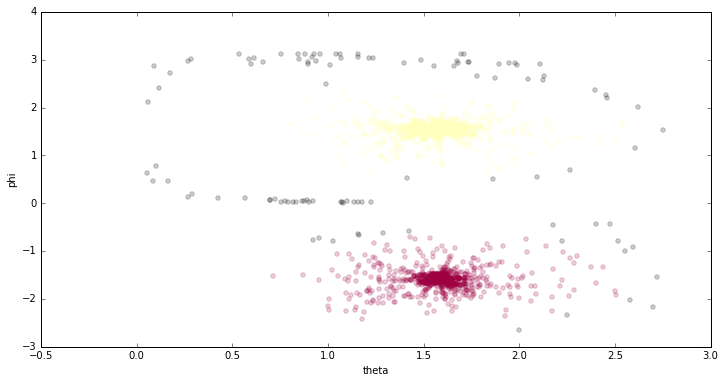

In [25]:
angular = to_angular(event_0)

samples = angular.shape[0]

from sklearn.cluster import DBSCAN
cls = DBSCAN(eps = 5.0e-1, min_samples=samples/10).fit(angular)

labels = cls.labels_

plt.figure(num=None, figsize=(12, 6), dpi=400)
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    plt.scatter(angular[class_member_mask, 0], angular[class_member_mask, 1], color=col, alpha=0.2)

plt.xlabel("theta")
plt.ylabel("phi")
plt.show()

In [9]:
class_boxes = list()

for label in unique_labels - set([-1]):
    members = angular[labels == label]
    theta_min = np.min(members[:, 0])
    theta_max = np.max(members[:, 0])
    phi_min = np.min(members[:, 1])
    phi_max = np.max(members[:, 1])
    class_boxes.append([theta_min, theta_max, phi_min, phi_max])

In [10]:
def plot_box(box):
    xmin, xmax, ymin, ymax = box
    plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], color="blue")

In [11]:
n = np.array([1, 0, 0])
print retina_response(n, event_0)
print retina_angular(0.0, 0.0, event_0)
print retina_response(from_angular(0.0, 0.0), event_0)

3.91042516313
3.91042516313
3.91042516313


In [12]:
response, thetas, phis = retina_response_grid(event_0, sigma=0.25, grid_bins=1000)

In [13]:
#response, thetas, phis = retina_response_grid(event_0, sigma=0.1, grid_bins=2000)

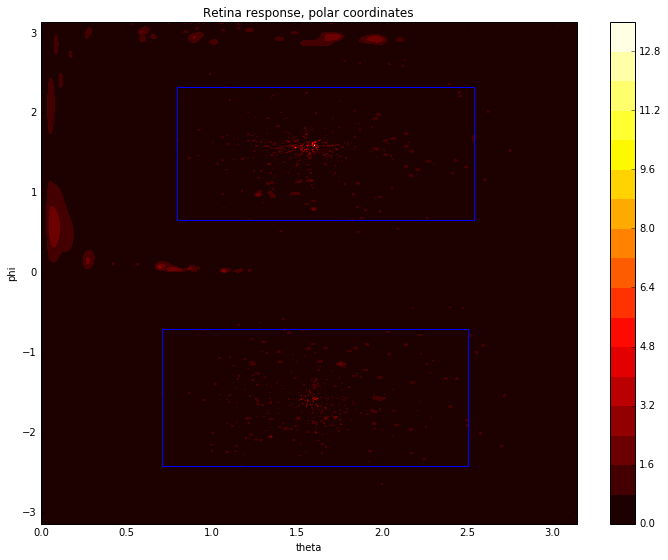

In [14]:
fig = plt.figure(num=None, figsize=(12, 9), dpi=800)
plt.contourf(thetas, phis, response, 20, cmap=plt.cm.hot)
plt.xlabel("theta")
plt.ylabel("phi")
plt.title("Retina response, polar coordinates")
plt.colorbar()
for box in class_boxes:
    plot_box(box)
plt.show()

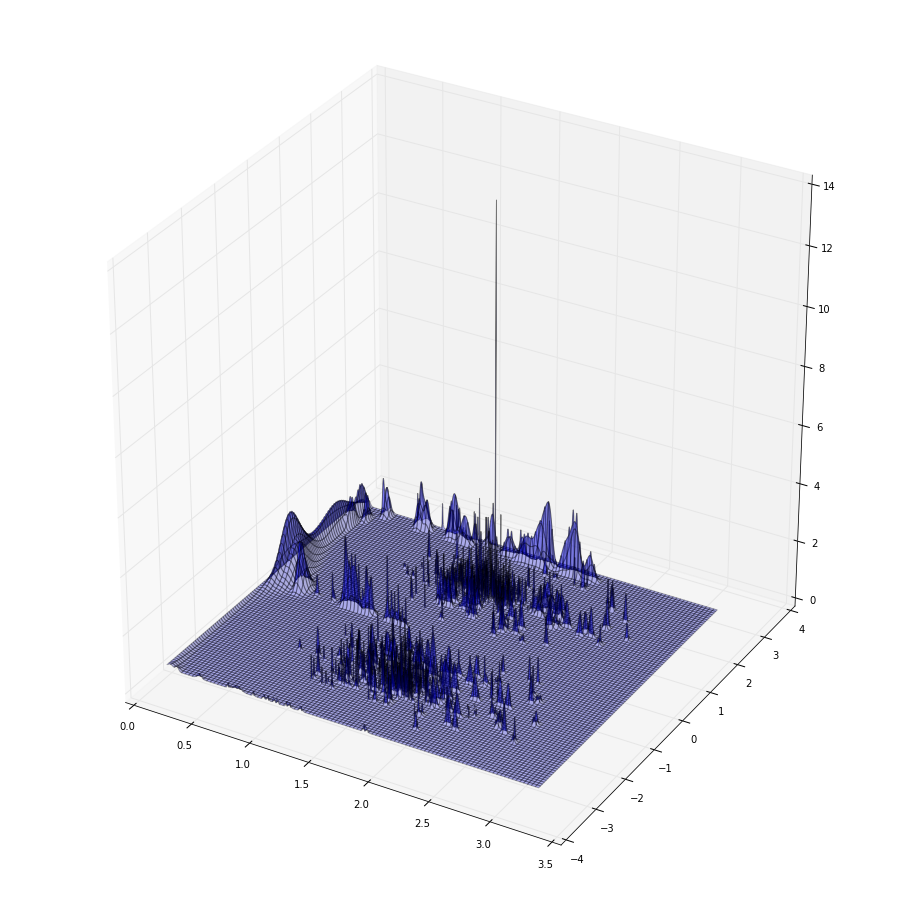

In [15]:
fig = plt.figure(num=None, figsize=(16, 16), dpi=800)
ax = fig.gca(projection='3d')
X, Y, Z = thetas, phis, response
ax.plot_surface(X, Y, Z, alpha=0.3)
#cset = ax.contour(X, Y, Z, zdir='z', offset=-0, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='y', offset=3.5, cmap=cm.coolwarm)

In [16]:
def local_maxima_grid(response, shifts = None):
    def shift(m, delta):
        shifted = m
        for (axis, d) in enumerate(delta):
            shifted = np.roll(shifted, d, axis)
        return shifted

    shifts = [ (s1, s2) for s1 in [-1, 0, 1] for s2 in [-1, 0, 1] if (s1, s2) != (0, 0) ]
    shifted = [ shift(response.copy(), delta) for delta in shifts ]
    maxima = np.ones(shape=response.shape, dtype="bool")

    for s in shifted:
        maxima = np.logical_and(maxima, response > s)
    return maxima

In [17]:
maxima = local_maxima_grid(response)
max_xs, max_ys = np.where(maxima)
maxima_thetas = thetas[max_xs, max_ys]
maxima_phis = phis[max_xs, max_ys]
track_response = response[max_xs, max_ys]

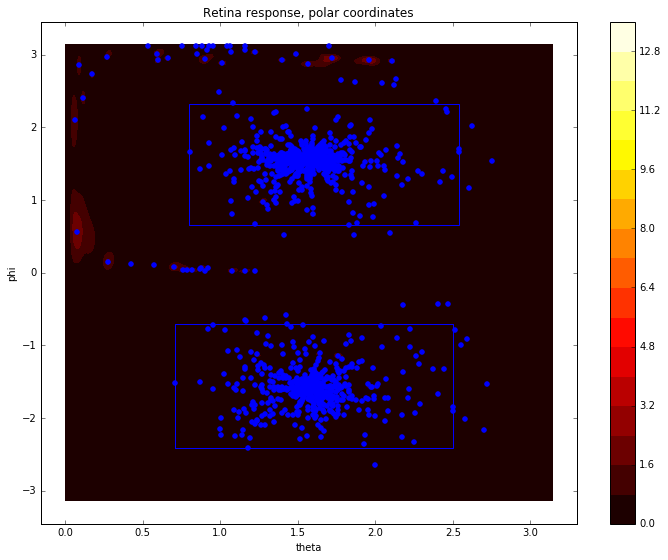

In [18]:
fig = plt.figure(num=None, figsize=(12, 9), dpi=800)
plt.contourf(thetas, phis, response, 20, cmap=plt.cm.hot)
plt.colorbar()
plt.scatter(thetas[max_xs, max_ys], phis[max_xs, max_ys], color="blue")
plt.xlabel("theta")
plt.ylabel("phi")
plt.title("Retina response, polar coordinates")
for box in class_boxes:
    plot_box(box)
plt.show()

In [19]:
tracks = from_angular(maxima_thetas, maxima_phis)

def normalize_tracks(event, ns):
    tracks = ns.copy()
    max_proj = np.max(event_0.dot(tracks.T), axis=0)
    tracks[:, 0] = ns[:, 0] * max_proj
    tracks[:, 1] = ns[:, 1] * max_proj
    tracks[:, 2] = ns[:, 2] * max_proj
    return tracks

tracks.shape

(1124, 3)

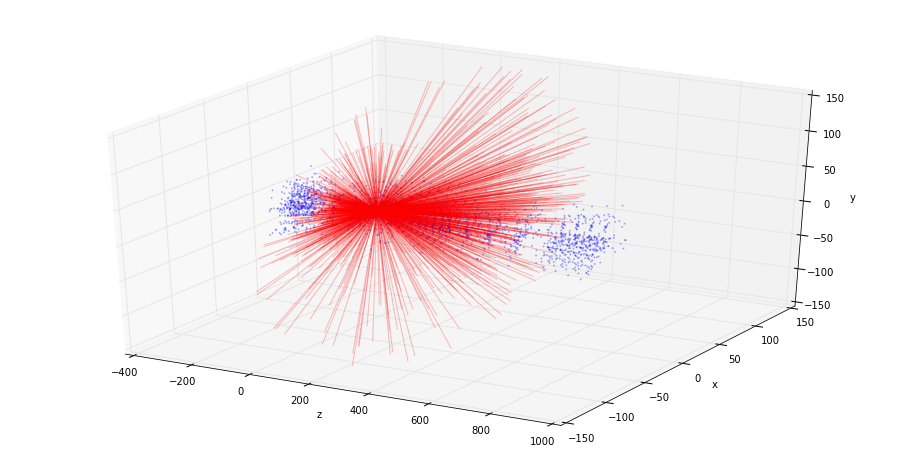

In [20]:
tracks_n = normalize_tracks(event_0, tracks)
plot_event(event_0, tracks_n / 2)

In [21]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

py.sign_in('carlos-castaneda', 'xno9347pjk')

In [22]:
def plot_event_plotly(event, tracks, track_response=None, name="retina"):
    def with_return_to_origin(t):
        t1 = np.zeros(t.shape[0] * 2)
        t1[1::2] = t
        return t1

    hits_3d = Scatter3d(
        x=event[:, 2],
        y= event[:, 0],
        z=event[:, 1],
        mode="markers",
        marker= {"size" : 3.0}
    )
    
    tracks_3d = Scatter3d (
        x=with_return_to_origin(tracks[:, 2]),  # x coords
        y=with_return_to_origin(tracks[:, 0]),  # y coords
        z=with_return_to_origin(tracks[:, 1]),  # z coords
        mode='lines',      # (!) draw lines between coords (as in Scatter)
        line=Line(
            color = "green",
            #color=track_response, # black line segments
            width=1,
            colorscale="Viridis"
          )
    )

    data = Data([hits_3d, tracks_3d])
    
    # Make a figure object
    fig = Figure(data=data)
    
    return py.iplot(fig, filename=name)

In [23]:
plot_event_plotly(event_0, tracks_n, track_response / track_response.max(), "retina_cut_0")

In [24]:
def cut_tracks(cut, tracks, response, max_xs, max_ys):
    c = response[max_xs, max_ys] > cut
    return tracks[c, :]